In [ ]:
import sys

sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py
import timm
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from timm import create_model
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader
import os
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.vision.all import L, unsqueeze
from timm.data.mixup import Mixup
from timm.loss import (
    LabelSmoothingCrossEntropy,
    BinaryCrossEntropy,
    SoftTargetCrossEntropy,
)
import random
from einops import rearrange

In [2]:
class RollTimeFreq:
    def __init__(self, shift_t_percent=0.3, shift_f_percent=0.3):
        self.shift_t_percent = shift_t_percent
        self.shift_f_percent = shift_f_percent

    def __call__(self, x):
        c, t, f = x.shape
        roll_t = np.random.randint(0, int(self.shift_t_percent * t))
        roll_f = np.random.randint(0, int(self.shift_f_percent * f))
        if np.random.rand() > 0.5:
            x = np.roll(x, roll_f, 2)

        if np.random.rand() > 0.5:
            k = [1, 0]
            x = x[k, ...]
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=1).copy()
        if np.random.rand() > 0.5:  # vertical flip
            x = np.flip(x, axis=2).copy()
        return x

In [3]:
def get_snr(left, right, df):
    df_ = pd.concat([df.query(f"snr>{left} & snr<{right}"), df.query("snr==0")])
    return df_


def generate_report(df, p, fn):
    pred = F.softmax(p).cpu().numpy()[:, 1]
    val_df_eval = df.copy()
    val_df_eval["pred"] = pred
    val_df_eval.to_csv(f'{fn}_oof.csv')

    roc_100 = roc_auc_score(val_df_eval["target"], val_df_eval["pred"])
    roc_50_100 = roc_auc_score(
        get_snr(50, 100, val_df_eval)["target"], get_snr(50, 100, val_df_eval)["pred"]
    )
    roc_0_50 = roc_auc_score(
        get_snr(0, 50, val_df_eval)["target"], get_snr(0, 50, val_df_eval)["pred"]
    )
    roc_0_40 = roc_auc_score(
        get_snr(0, 40, val_df_eval)["target"], get_snr(0, 40, val_df_eval)["pred"]
    )
    roc_0_30 = roc_auc_score(
        get_snr(0, 30, val_df_eval)["target"], get_snr(0, 30, val_df_eval)["pred"]
    )

    roc_0_20 = roc_auc_score(
        get_snr(0, 20, val_df_eval)["target"], get_snr(0, 20, val_df_eval)["pred"]
    )
    


    return {
        "roc_all": roc_100,
        "roc_50_100": roc_50_100,
        "roc_0_50": roc_0_50,
        "roc_0_40": roc_0_40,
        "roc_0_30": roc_0_30,
        "roc_0_20": roc_0_20,
    }

In [4]:
class SaveModel:
    def __init__(self, folder, exp_name, best=np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score < self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelMetric:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder) / f"{exp_name}.pth"

    def __call__(self, score, model, epoch):
        if score > self.best:
            self.best = score
            print(f"Better model found at epoch {epoch} with value: {self.best}.")
            torch.save(model.state_dict(), self.folder)


class SaveModelEpoch:
    def __init__(self, folder, exp_name, best=-np.inf):
        self.best = best
        self.folder = Path(folder)
        self.exp_name = exp_name

    def __call__(self, score, model, epoch):
        self.best = score
        print(f"Better model found at epoch {epoch} with value: {self.best}.")
        torch.save(model.state_dict(), f"{self.folder/self.exp_name}_{epoch}.pth")


def custom_auc_score(p, gt):
    return roc_auc_score(gt.cpu().numpy(), F.softmax(p).cpu().numpy()[:, 1])


def fit_mixup(
    epochs,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    metric,
    val_df,
    folder="models",
    exp_name="exp_00",
    device=None,
    sched=None,
    mixup_=False,
    save_md=SaveModelEpoch,
):
    if device is None:
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    os.makedirs(folder, exist_ok=True)
    loss_fn_trn = loss_fn
    if mixup_:
        mixup = Mixup(
            num_classes=2, mixup_alpha=0.4, prob=0.8
        )
        loss_fn_trn = BinaryCrossEntropy()
    mb = master_bar(range(epochs))
    
   
    mb.write(["epoch", 
              "train_loss",
              "valid_loss",
              "val_metric",
              "roc_all",
              "roc_50_100", 
              "roc_0_50", 
              "roc_0_40", 
              "roc_0_30", 
              "roc_0_20"], table=True)
    model.to(device)  # we have to put our model on gpu
    scaler = torch.cuda.amp.GradScaler()  # this for half precision training
    save_md = save_md(folder, exp_name)

    for i in mb:  # iterating  epoch
        trn_loss, val_loss = 0.0, 0.0
        trn_n, val_n = len(train_dl.dataset), len(valid_dl.dataset)
        model.train()  # set model for training
        for (xb, yb) in progress_bar(train_dl, parent=mb):
            xb, yb = xb.to(device), yb.to(device)  # putting batches to device
            if mixup_:
                xb, yb = mixup(xb, yb)
            with torch.cuda.amp.autocast():  # half precision
                out = model(xb)  # forward pass
                loss = loss_fn_trn(out, yb)  # calulation loss

            trn_loss += loss.item()
            opt.zero_grad()  # zeroing optimizer
            scaler.scale(loss).backward()  # backward
            scaler.step(opt)  # optimzers step
            scaler.update()  # for half precision
            if sched is not None:
                sched.step()  # scuedular step

        trn_loss /= mb.child.total

        # putting model in eval mode
        model.eval()
        gt = []
        pred = []
        # after epooch is done we can run a validation dataloder and see how are doing
        with torch.no_grad():
            for (xb, yb) in progress_bar(valid_dl, parent=mb):
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out, yb)
                val_loss += loss.item()

                gt.append(yb.detach())
                pred.append(out.detach())
        # calculating metric
        metric_ = metric(torch.cat(pred), torch.cat(gt))
        # saving model if necessary
        save_md(metric_, model, i)
        val_loss /= mb.child.total
        dict_res = generate_report(val_df, torch.cat(pred), f"{folder}/{exp_name}_{i}")
            
        pd.DataFrame(
            {
                "trn_loss": [trn_loss],
                "val_loss": [val_loss],
                "metric": [metric_],
                "roc_all": [dict_res["roc_all"]],
                "roc_50_100": [dict_res["roc_50_100"]],
                "roc_0_50": [dict_res["roc_0_50"]],
                "roc_0_40": [dict_res["roc_0_40"]],
                "roc_0_30": [dict_res["roc_0_30"]],
                "roc_0_20": [dict_res["roc_0_20"]],
            }
        ).to_csv(f"{folder}/{exp_name}_{i}.csv", index=False)
        mb.write(
            [
                i,
                f"{trn_loss:.6f}",
                f"{val_loss:.6f}",
                f"{metric_:.6f}",
                f"{dict_res['roc_all']:.6f}",
                f"{dict_res['roc_50_100']:.6f}",
                f"{dict_res['roc_0_50']:.6f}",
                f"{dict_res['roc_0_40']:.6f}",
                f"{dict_res['roc_0_30']:.6f}",
                f"{dict_res['roc_0_20']:.6f}",
            ],
            table=True,
        )
    print("Training done")
    # loading the best checkpoint

In [5]:
def freq_mask(spec, F=20, num_masks=2, replace_with_zero=True):
    cloned = spec.clone().detach()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, np.random.randint(1, num_masks)):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[:, f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

def time_mask(spec, T=20, num_masks=3, replace_with_zero=True):
    cloned = spec.clone().detach()
    len_spectro = cloned.shape[2]
    
    for i in range(0, np.random.randint(1, num_masks)):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[:, :,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned



In [6]:

def scale_data(data):
     return (data-np.min(data))/(np.max(data)-np.min(data))

class DataV0():
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, tfms=False):
        self.df = df
        self.tfms = tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        data=torch.load(r.id)
        img = np.empty((2, 360, 128), dtype=np.float32)

        for ch, s in enumerate(['H1', 'L1']):
            p = data[s]
            p /= np.mean(p)  # normalize
            p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
            img[ch] = p
        if self.tfms:
            if np.random.rand() <= 0.5: # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= 0.5: # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= 0.5: # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            if np.random.rand() > 0.5:
                img = freq_mask(torch.tensor(img))
            if np.random.rand() > 0.5:
                img = time_mask(torch.tensor(img))
        return np.array(img), y.astype('int')

In [7]:
class CFG:
    bs = 32
    nw = 4
    model_name = "tf_efficientnet_b7_ns"
    lr = 1e-4
    wd = 1e-4
    epoch = 10
    warmup_pct = 0.1
    num_classes = 2
    dropout_rate = 0.3
    folder = "EXP_30_02"
    split_voldf = Path("../data/SPLITS/V_19")
    mixup=False
    exp_name = f"{folder}_{model_name}_{split_voldf.stem}_{mixup}"

In [8]:
dforig = pd.read_csv('../data/train_labels.csv')
dforig.columns = ['fn', 'target']
dforig['fn'] = dforig['fn'].apply(lambda x: Path('../data/train')/f'{x}.hdf5')
dforig.columns = ['id', 'target']
dforig['id'] = dforig['id'].apply(lambda x: str(x).replace('.hdf5', '.pth'))
#dforig = dforig[dforig.target >= 0].reset_index(drop=True)
trn_df = pd.read_csv(CFG.split_voldf/'trn_df.csv')
trn_df['id'] = trn_df['id'].apply(lambda x: x.replace('.h5', '.pth'))

val_df = pd.read_csv(CFG.split_voldf/'val_df.csv')
val_df['id'] = val_df['id'].apply(lambda x: x.replace('.h5', '.pth'))
trn_df = pd.concat([dforig.query('target==0').reset_index(drop=True), trn_df]).sample(frac=1)
trn_df.shape,  val_df.shape

((20831, 13), (7500, 13))

/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))


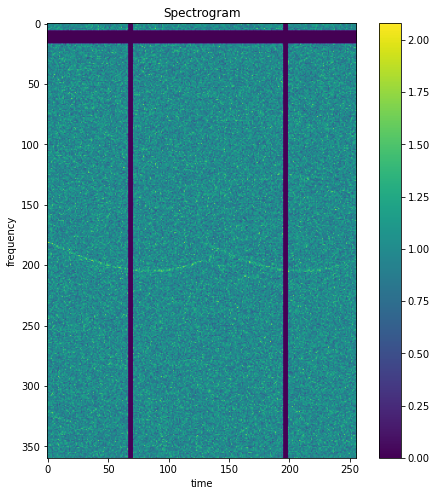

1


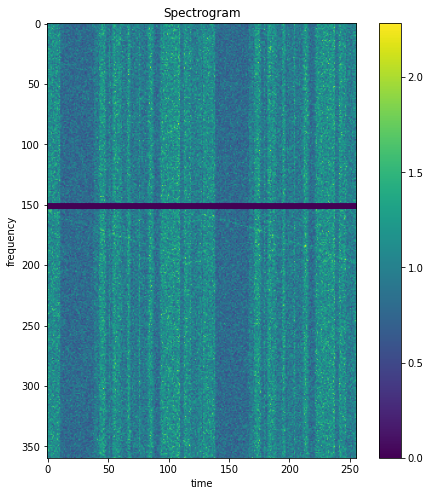

1


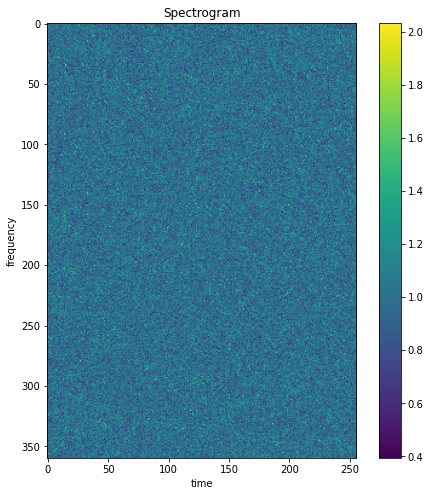

1


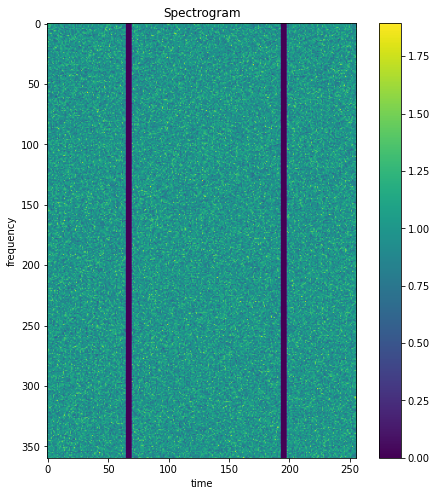

0


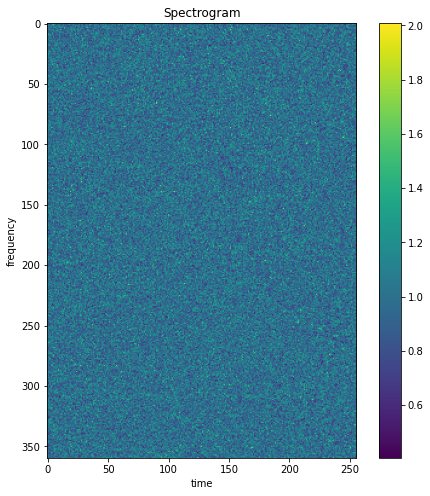

1


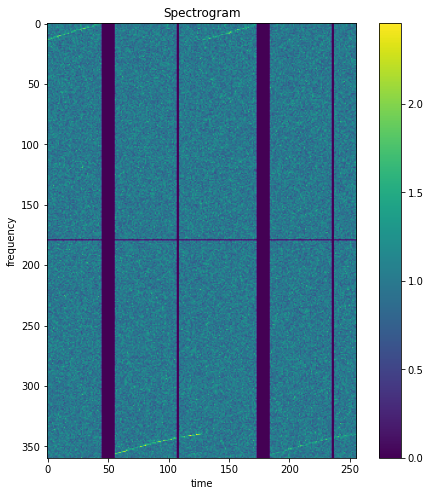

1


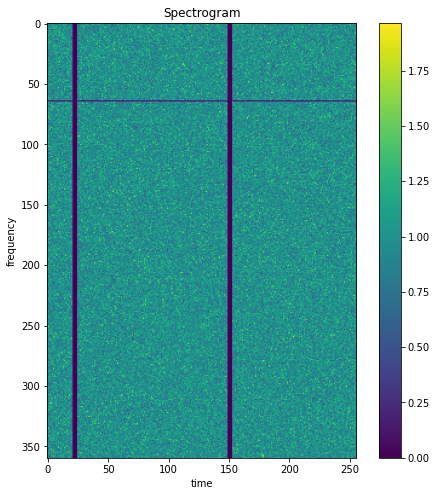

0


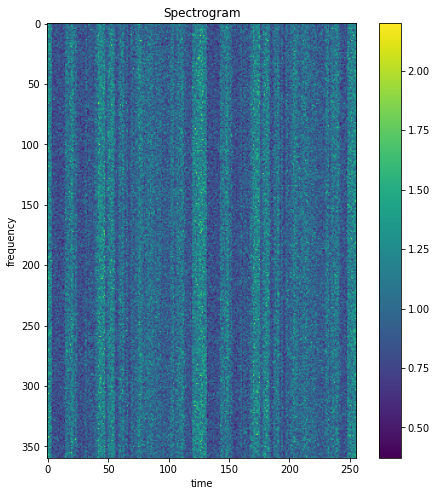

1


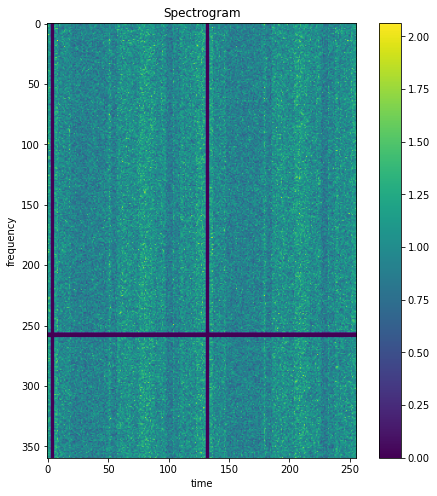

0


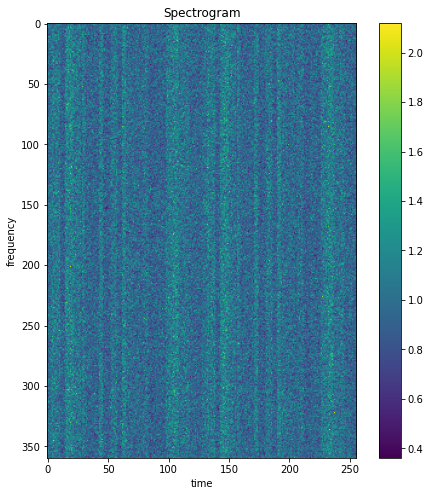

0


In [9]:
dataset =  DataV0(trn_df, True)


for i in range(10):
    img, y = dataset[np.random.randint(0, len(dataset))]
    #img, y = dataset[i]
    plt.figure(figsize=(8, 8))
    plt.title('Spectrogram')
    plt.xlabel('time')
    plt.ylabel('frequency')
    plt.imshow(np.concatenate([img[0], img[1]], 1))  # zooming in for dataset[10]
    plt.colorbar()
    plt.show()
    print(y)
    plt.pause(0.1)

    

In [10]:
gt = []
preds = []
fold = 0

# Train - val split
trn_ds = DataV0(trn_df, True)
vld_ds = DataV0(val_df)

trn_dl = DataLoader(
    trn_ds,
    batch_size=CFG.bs,
    shuffle=True,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=True,
)
vld_dl = DataLoader(
    vld_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)


custom_model = create_model(
    CFG.model_name,
    pretrained=True,
    num_classes=CFG.num_classes,
    in_chans=2,
    drop_rate = 0.3,
)
opt = torch.optim.AdamW(custom_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
loss_func = nn.CrossEntropyLoss()
warmup_steps = int(len(trn_dl) * int(CFG.warmup_pct * CFG.epoch))
total_steps = int(len(trn_dl) * CFG.epoch)
sched = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

fit_mixup(
    epochs=CFG.epoch,
    model=custom_model,
    train_dl=trn_dl,
    valid_dl=vld_dl,
    loss_fn=loss_func,
    opt=opt,
    val_df = val_df,
    metric=custom_auc_score,
    folder=CFG.folder,
    exp_name=f"{CFG.exp_name}_{fold}",
    device="cuda:0",
    sched=sched,
    mixup_ = CFG.mixup
)
del custom_model
del trn_dl
del vld_dl
import gc

gc.collect()

epoch,train_loss,valid_loss,val_metric,roc_all,roc_50_100,roc_0_50,roc_0_40,roc_0_30,roc_0_20
0,1.557628,0.756927,0.639153,0.639153,0.769155,0.541652,0.534026,0.521721,0.485072
1,0.654108,0.587052,0.702508,0.702508,0.915656,0.542647,0.527553,0.514768,0.495814
2,0.570680,0.560722,0.721431,0.721431,0.948009,0.551497,0.525515,0.515671,0.511195
3,0.545575,0.543248,0.725343,0.725343,0.951436,0.555774,0.529842,0.519865,0.513634
4,0.533995,0.540888,0.729617,0.729617,0.956180,0.559694,0.527749,0.518316,0.504403
5,0.523152,0.544003,0.735087,0.735087,0.961708,0.565121,0.531348,0.529064,0.512390
6,0.516053,0.532871,0.741250,0.741250,0.965967,0.572711,0.533523,0.515465,0.500883
7,0.509429,0.525015,0.739495,0.739495,0.966683,0.569104,0.530773,0.521928,0.523368
8,0.506806,0.562471,0.704869,0.704869,0.918487,0.544655,0.531697,0.534335,0.517045
9,0.500993,0.519483,0.751936,0.751936,0.972282,0.586677,0.544622,0.532411,0.519317


/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Better model found at epoch 0 with value: 0.6391533214285714.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 1 with value: 0.7025083928571428.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 2 with value: 0.7214308928571428.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 3 with value: 0.7253433928571428.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 4 with value: 0.7296166785714285.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 5 with value: 0.7350868214285714.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 6 with value: 0.7412495357142858.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 7 with value: 0.7394952142857143.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 8 with value: 0.7048685.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time_mask(torch.tensor(img))
/tmp/ipykernel_1651163/2130421750.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = time

Better model found at epoch 9 with value: 0.751936.


/tmp/ipykernel_1651163/1909403160.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(p).cpu().numpy()[:, 1]


Training done


88

In [12]:
class TimmFeatureExtractor(nn.Module):
    def __init__(self, model_name, n_class, weights):
        super().__init__()
        self.md = create_model(
            model_name,
            pretrained=False,
            num_classes=n_class,
            in_chans=2,
        )
        print(f"loading: {weights}")
        self.md.load_state_dict(torch.load(weights))

    def forward(self, x):
        with torch.no_grad():
            out = F.softmax(self.md(x))
        return out
    
    
class AverageModel(nn.Module):
    def __init__(self, model_list):
        super().__init__()
        self.model_list = model_list
        
    def forward(self, x):
        res = []
        for md in self.model_list:
            res.append(md(x).detach().cpu())
        return torch.stack(res).mean(0)

In [13]:
class DataV0():
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.freq_tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        filename=r.id
        file_id = Path(r.id).stem
        img = np.empty((2, 360, 128), dtype=np.float32)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2  # power
                p /= np.mean(p)  # normalize
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
                img[ch] = p
        if self.freq_tfms:
            if np.random.rand()>0.5:
                img = self.freq_tfms(img)

        return img, y.astype('int')

In [14]:
epoch = 9
md_wts = [f"{CFG.folder}/{CFG.exp_name}_0_{epoch}.pth"]
md_wts

['EXP_30_02/EXP_30_02_tf_efficientnet_b7_ns_V_19_False_0_9.pth']

In [15]:
md = AverageModel(
    [
        TimmFeatureExtractor(CFG.model_name, CFG.num_classes, md_wts[0]).cuda().eval(),
    ]
)


loading: EXP_30_02/EXP_30_02_tf_efficientnet_b7_ns_V_19_False_0_9.pth


In [16]:
submit = pd.read_csv('../data/sample_submission.csv')
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: Path('../data/test')/f'{x}.hdf5')
submit.columns = ['id', 'target']
tst_ds = DataV0(submit)
tst_dl = DataLoader(
    tst_ds,
    batch_size=64,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
)

res = []
with torch.no_grad():
    for x, y in tqdm(tst_dl):
        out = md(x.cuda())
        res.append(out[:, 1].numpy())



submit['target'] = np.concatenate(res)
submit.columns = ['fn', 'target']
submit['fn'] = submit['fn'].apply(lambda x: x.stem)
submit.columns = ['id', 'target']
os.makedirs('../data/SUBS', exist_ok=True)
submit.to_csv(f'../data/SUBS/{CFG.model_name}_{CFG.exp_name}.csv', index=False)


  0%|                                                                                          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_1651163/3973058501.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.md(x))
100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [07:00<00:00,  3.36s/it]


<AxesSubplot:ylabel='Frequency'>

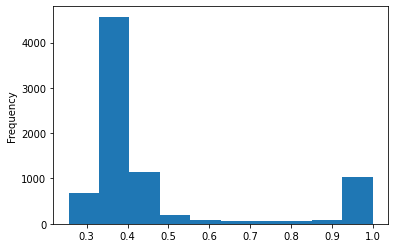

In [17]:
submit['target'].plot.hist()

In [18]:
for i in range(20):
    if np.random.rand()>0.8:
        print(i)

0
6
9
16
